In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import time
from sklearn.model_selection import train_test_split
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Convert classes to indicator vectors
def one_hot(values,n_values=51):
    n_v = np.maximum(n_values, np.max(values) + 1)
    oh = np.eye(n_v)[values]
    return oh

In [0]:
frame_data = np.float16(np.load('drive/My Drive/Computer Vision/HMDB/saved_training/frame_data_5_frame_flat_OPTFLOW_1544641757.npy'))
labels = np.load('drive/My Drive/Computer Vision/HMDB/saved_training/labels_5_frame_OPTFLOW_1544641757.npy')

n = 0
class_labels = {}
new_labels = []
for l in labels:
  if l in class_labels:
    new_labels.append(class_labels[l])
  else:
    class_labels[l] = n
    new_labels.append(n)
    n += 1
labels = one_hot(np.array(new_labels))

train_data, test_data, train_labels, test_labels = train_test_split(frame_data, labels, test_size=0.1, random_state=102)
val_data = train_data[int(0.9 * len(train_data)):len(train_data)]
val_labels = np.int16(train_labels[int(0.9 * len(train_data)):len(train_labels)])
train_data = train_data[0:int(0.9 * len(train_data))]
train_labels = np.int16(train_labels[0:int(0.9 * len(train_labels))])

# train_data = frame_data[0:int(0.7 * len(frame_data))]
# train_labels = one_hot(np.int16(labels[0:int(0.7 * len(frame_data))]))
# val_data = frame_data[int(0.7 * len(frame_data)):int(0.85 * len(frame_data))]
# val_labels = one_hot(np.int16(labels[int(0.7 * len(frame_data)):int(0.85 * len(frame_data))]))
# test_data = frame_data[int(0.85 * len(frame_data)):len(frame_data)]
# test_labels = one_hot(np.int16(labels[int(0.85 * len(frame_data)):len(frame_data)]))



In [0]:
def conv_relu_layer(input, filter_size=[3,3], num_features=[1]):
    # Get number of input features from input and add to shape of new layer
    shape = filter_size + [input.get_shape().as_list()[-1], num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

In [0]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened
    flat_dim = np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape = [flat_dim,num_features]
    W_fc = tf.get_variable('W', shape=shape) 
    b_fc = tf.get_variable('b', shape=[num_features], initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [0]:
#tf.reset_default_graph()

def create_network(scale):
    pool_ksize = [1,2,2,1]
    pool_strides = [1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32*scale)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64*scale)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128*scale)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=51)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float16), name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [0]:
# Get loss and accuracy on a data set with output from final layer fc2

from scipy.special import logsumexp

def get_stats(data,labels):
    t1 = time.time()
    loss = 0.
    acc = 0.
    delta = 1000
    rr = np.arange(0, data.shape[0], delta)
    for i in rr:
        fc2_out = fc2.eval(feed_dict={x: data[i:i + delta], y_:labels[i:i + delta]})
        log_sf = logsumexp(fc2_out, axis=1).reshape((fc2_out.shape[0], 1)) - fc2_out
        loss += np.mean(np.sum(labels[i:i+delta] * log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc = acc/np.float32(len(rr))
    loss = loss/np.float32(len(rr))
    print('Stats time:', time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return loss, acc

In [0]:
# Run the iterations of one epoch
def run_epoch(tdata, tlabels, ii, batch_size, train_step_new):
  t1 = time.time()
  # Randomly shuffle the training data
  np.random.shuffle(ii)
  tr = tdata[ii]
  y = tlabels[ii]
  loss = 0.
  acc = 0.
  # Run disjoint batches on shuffled data
  for j in np.arange(0, len(y), batch_size):
    if (np.mod(j, 5000) == 0):
      print('Batch', j/batch_size)
    batch =(tr[j:j+batch_size], y[j:j+batch_size])
    train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size, keep_prob_:keep_prob})
  print('Epoch Time:', time.time() - t1)

In [11]:
print(train_data.shape)

# Run the training

import time
batch_size = 100
step_size = 0.001
num_epochs = 15
num_train = 1000
minimizer = "Adam"
model_name = "model1"
keep_prob = 0.5
dim1 = 128
dim2 = 128
nchannels = 1

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim1*dim2*nchannels], name="x")
x_image = tf.reshape(x, [-1, dim1, dim2, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,51], name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[], name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[], name="keep_prob")

with tf.Session() as sess:
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 = create_network(1)

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step = tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
#         # Show trainable variables
#         total_parameters = 0
#         for v in tf.trainable_variables():
#             print(v.name, v.get_shape().as_list(), np.std(v.eval()))
#             shape = v.get_shape()
#             var_parameters = 1
#             for dim1 in shape:
#                 var_parameters = var_parameters * dim1.value
#             total_parameters += var_parameters
        ii = np.arange(0, num_train, 1) 
        # Run epochs
        train_error_original = []
        validation_error_original = []
        for i in range(num_epochs):  # number of epochs
            run_epoch(train_data, train_labels, ii, batch_size, train_step)
            loss, acc = get_stats(train_data[0:num_train], train_labels[0:num_train])
            train_error_original.append(1 - acc)
            print('Epoch:', i,'Train loss:', loss, 'Accuracy:', acc)
            vloss, vacc = get_stats(val_data, val_labels)
            validation_error_original.append(1 - vacc)
            print('Epoch',i,'Validation loss', vloss, 'Accuracy', vacc)

        print('Test Accuracy %g' % accuracy.eval(feed_dict={x: test_data, y_:test_labels}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "drive/My Drive/Computer Vision/saved_models/" + model_name)
        print("Model saved in path: %s" % save_path)
#        print("Total number of parameters: %s" % total_parameters)

        conv1_W = sess.run(tf.trainable_variables()[0])

(27548, 16384)
Batch 0.0
Epoch Time: 1.3319659233093262
Stats time: 0.4272782802581787
Epoch: 0 Train loss: 3.891650438308716 Accuracy: 0.067
[ 0.     0.     0.    ... 12.1    6.688  1.875] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Stats time: 1.256178855895996
Epoch 0 Validation loss 3.926836371421814 Accuracy 0.029098360655737707
Batch 0.0
Epoch Time: 1.1228604316711426
Stats time: 0.40561628341674805
Epoch: 1 Train loss: 3.701124429702759 Accuracy: 0.121
[ 0.     0.     0.    ... 12.1    6.688  1.875] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Stats time: 1.2454485893249512
Epoch 1 Validation loss 3.9135794043540955 Accuracy 0.07434016393442623
Batch 0.0
Epoch Time: 1.1268043518066406
Stats time: 0.40770649909973145
Epoch: 2 Train loss: 3.0321288108825684 Accuracy: 0.356
[ 0.     0.     0.    ... 12.1    6.688  1.875] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

ResourceExhaustedError: ignored

Text(0.5,1,'Error Rate on Training Data by Epoch')

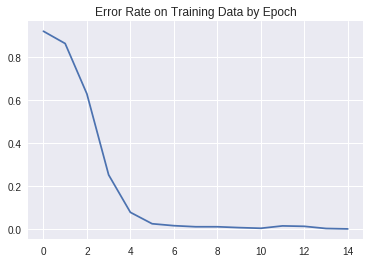

In [10]:
plt.plot(range(num_epochs), train_error_original)
plt.title("Error Rate on Training Data by Epoch")